# Figure 4a

Correlations stuff

In [10]:
import os
import sys

import numpy as np
import pandas as pd

from tqdm import tqdm
from IPython.display import clear_output

import matplotlib as mpl 
import matplotlib.pyplot as plt

sys.path.insert(0, '../../icenumerics/')
sys.path.insert(0, './auxnumerics/')
import icenumerics as ice

import auxiliary as aux
import montecarlo_tools as mc
import chirality_tools as chir
from parameters import params
ureg = ice.ureg

%reload_ext autoreload
%autoreload 2

idx = pd.IndexSlice

In [11]:
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

# Parameters

In [12]:
quench_time = 300*ureg.s
evolution_time = 60*ureg.s
total_time = 6000*ureg.s
sim_path = '/media/eru/ina/stuckgs/data/simstair_detailed'
data_path = '/media/eru/ina/stuckgs/data/'

## Correlations

Here I will generalte all the correlation timeseries for all realizations for all particles.

In [14]:
data = pd.read_csv(os.path.join(sim_path,'rparallels.csv'), index_col=[0,1])
data

0       1         2         3         4         5  \
realization frame                                                            
1           0      1.50000 -1.5000  1.500000 -1.500000 -1.500000  1.500000   
            1      1.49456 -1.4564  0.992100 -1.444000 -1.513203  1.078800   
            2      1.28003 -1.2973  0.538601 -0.980000 -1.447403  1.480103   
            3      0.89152 -0.3553 -0.053999 -1.153601 -1.467403  1.489300   
            4      1.48128  0.1644  0.268600 -1.048599 -1.370102  0.955303   
...                    ...     ...       ...       ...       ...       ...   
10          5995   1.50855 -1.5110  1.355400 -1.328899  1.364799 -1.160900   
            5996   1.48046 -1.5021  1.413101 -1.471300  1.305199 -1.090797   
            5997   1.51158 -1.5041  1.370600 -1.432501  1.337398 -1.197197   
            5998   1.50754 -1.5064  1.407501 -1.440901  1.369099 -1.212597   
            5999   1.50508 -1.5084  1.469801 -1.379499  1.468998 -1.236698   

                          6         7         8         9  ...      1790  \
realization frame                                          ...             
1           0     -1.500000 -1.500000  1.500000  1.500000  ... -1.500000   
            1     -1.331398 -0.484798  1.399101  1.059097  ... -1.182999   
            2     -1.431499 -0.326000  0.400597  1.370300  ... -1.450012   
            3     -1.188297 -0.204498  0.446503  1.172302  ... -1.459000   
            4     -0.215797  0.108799 -0.055099  0.903702  ... -1.328003   
...                     ...       ...       ...       ...  ...       ...   
10          5995   1.222099 -1.431400  1.356499 -1.379799  ... -1.536011   
            5996   1.189701 -1.330601  1.404198 -1.388100  ... -1.539001   
            5997   1.255600 -1.390400  1.363503 -1.376900  ... -1.540008   
            5998   1.259399 -1.284901  1.413002 -1.366600  ... -1.539001   
            5999   1.157101 -1.330498  1.397003 -1.400902  ... -1.542007   

                       1791      1792      1793      1794      1795      1796  \
realization frame                                                               
1           0     -1.500000 -1.500000 -1.500000 -1.500000 -1.500000  1.500000   
            1     -1.100998 -1.283005 -1.419006 -1.322006 -1.251999  1.334992   
            2     -0.983002 -1.223999 -1.441010 -1.262009 -1.184998  1.435989   
            3     -0.112000 -1.430008 -1.147003 -1.498001 -1.180008  1.330994   
            4     -1.301010 -1.233002 -1.087006 -1.156006 -1.128006  1.153000   
...                     ...       ...       ...       ...       ...       ...   
10          5995   1.532990 -1.536011  1.532990 -1.534012  1.541000 -1.529999   
            5996   1.535996 -1.526001  1.526001 -1.538010  1.529999 -1.535004   
            5997   1.526001 -1.527008  1.537003 -1.525009  1.534988 -1.522003   
            5998   1.537003 -1.540008  1.524002 -1.546005  1.526001 -1.528000   
            5999   1.534988 -1.536011  1.526001 -1.526001  1.531998 -1.546005   

                       1797      1798      1799  
realization frame                                
1           0      1.500000 -1.500000 -1.500000  
            1      1.360992 -1.431000 -0.751007  
            2      1.489990 -1.040008 -1.181000  
            3      1.103989 -1.276001 -0.919006  
            4      1.238998 -1.299011 -1.264008  
...                     ...       ...       ...  
10          5995   1.529999 -1.542007  1.541992  
            5996   1.531998 -1.520004  1.524994  
            5997   1.524002 -1.544006  1.528992  
            5998   1.530991 -1.531998  1.531998  
            5999   1.546997 -1.536011  1.521988  

[60000 rows x 1800 columns]

In [15]:
realizations = data.index.get_level_values('realization').unique().to_list()

h = 300
intervals = [
 (30, 330),
 (360, 660),
 (690, 990),
 (1020, 1320),
 (1350, 1650),
 (1680, 1980),
 (2010, 2310),
 (2340, 2640),
 (2670, 2970),
 (3000, 3300),
]

intervals = [
    (30,330), 
    (333,633),
    (636,936),
    (939,1239),
    (1242,1542),
    (1545,1845),
    (1848,2148),
    (2151,2451),
    (2454,2754),
    (2757,3057),
    (3060,3360),
    (3390,3690),
    (3720,4020),
    (4050,4350),
    (4380,4680),
    (4710,5010),
    (5040,5340),
    (5370,5670),
    (5700,6000),
]

In [16]:
def correlate_realization(sim_path,data,realization,interval,s,e):
    """
        This calculates the correlations functions for all particles in a given time interval.
        Saves all the data.
    """
    
    # Selecting the appropiate realization and its frames
    cdata = data.loc[idx[realization,:]]
    sframes = cdata.index.get_level_values('frame').unique().to_list()
    particle_ids = data.columns
    
    # Selecting all the particles time-selies
    cts = cdata[particle_ids].to_numpy().transpose()
    subselframes, correlations = aux.correlate_bframes(params,cts,sframes,stime=s,etime=e)

    # Making the appropiate df
    corr_df = pd.DataFrame(np.array(correlations).transpose()) # Putting each time-series as columns
    numbered = list(corr_df.columns)
    corr_df['frame'] = subselframes
    corr_df['realization'] = [realization] * len(subselframes)
    corr_df[['realization','frame'] + numbered]

    if realization == 1:
        corr_df.to_csv(os.path.join(sim_path,f'corr{interval}.csv'), index=False)
    else:
        corr_df.to_csv(os.path.join(sim_path,f'corr{interval}.csv'), index=False, header=False, mode='a')
    


In [17]:
corr_path = '/media/eru/ina/stuckgs/data/figs/correlations'
for i,(s,e) in enumerate(intervals):
    print(f'Interval ({s},{e})')
    for realization in realizations:
        correlate_realization(corr_path,data,realization,i,s,e)

Interval (30,330)
Interval (333,633)
Interval (636,936)
Interval (939,1239)
Interval (1242,1542)
Interval (1545,1845)
Interval (1848,2148)
Interval (2151,2451)
Interval (2454,2754)
Interval (2757,3057)
Interval (3060,3360)
Interval (3390,3690)
Interval (3720,4020)
Interval (4050,4350)
Interval (4380,4680)
Interval (4710,5010)
Interval (5040,5340)
Interval (5370,5670)
Interval (5700,6000)


## Averages

Now it is time to load them one by one and take the averages, std, normalize and stuff.

In [18]:
for interval in range(len(intervals)):
    avs = []
    for realization in realizations:
        corr_int = pd.read_csv(os.path.join(corr_path,f'corr{interval}.csv'),index_col=['realization','frame'])
        frames = corr_int.index.get_level_values('frame').unique().to_numpy()
        dt = (frames - frames[0]) / params['framespersec'].magnitude
        
        particle_average = corr_int.loc[idx[realization,:]].mean(axis=1)
        particle_average = particle_average / particle_average.max()
        avs.append(particle_average.to_list())

    df = pd.DataFrame( np.array(avs).mean(axis=0), columns=['av'])
    df['dt'] = dt
    df['interval'] = [interval] * len(frames)

    if interval == 0:
        df.to_csv(os.path.join(corr_path,'global.csv'), index=False)
    else:
        df.to_csv(os.path.join(corr_path,'global.csv'), index=False,mode = 'a', header=False)



## Visualization

In [19]:
corravs = pd.read_csv(os.path.join(corr_path,'global.csv'), index_col=['interval','dt'])
nintervals = corravs.index.get_level_values('interval').unique().to_list()

In [23]:
rate = params['max_field']/quench_time
fields = [1 + i/10 for i in range(10)] + [i for i in range(2,11)]
fields


[1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2, 3, 4, 5, 6, 7, 8, 9, 10]

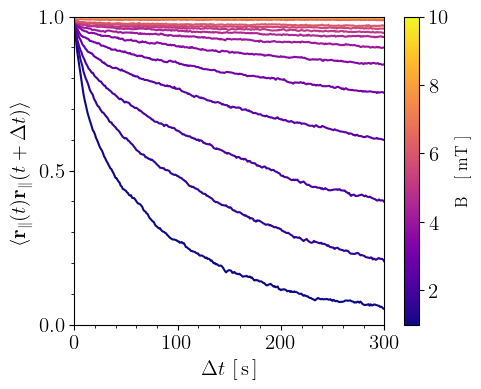

In [27]:
fig, ax = plt.subplots(figsize = (5,4))
cmap = plt.get_cmap('plasma')

for interval, (i,B) in zip(nintervals, enumerate(fields)):
    color =  cmap(i / (len(fields) - 1))
    avi = corravs.loc[idx[interval,'av']]
    #ax.loglog(avi.index.to_list(),avi.to_list(), color=color)
    ax.plot(avi.index.to_list(),avi.to_list(), color=color)

ax.set_xlim(0,h)
ax.set_ylim(0,1)
ax.set_xlabel("$\\Delta t$ [\\,s\\,]", fontsize=15)
ax.set_ylabel("$\\langle \\mathbf{r}_\\parallel(t) \\mathbf{r}_\\parallel(t+\\Delta t)\\rangle$",fontsize=15)

ax.xaxis.set_major_locator(plt.MultipleLocator(100))
ax.xaxis.set_minor_locator(plt.NullLocator())
ax.xaxis.set_minor_formatter(plt.NullFormatter())


ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_minor_locator(plt.NullLocator())
ax.yaxis.set_minor_formatter(plt.NullFormatter())

ax.tick_params(axis='both', which='major', labelsize=15)
ax.minorticks_on()

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=1, vmax=10))
sm.set_array([])
cbar = plt.colorbar(sm,ax=ax)
cbar.set_label(label='B \\,\\, [ mT ]',size='large')
cbar.ax.tick_params(labelsize=15)

fig.savefig(os.path.join(data_path,'figs/fig4a.png'),dpi=300,bbox_inches='tight')
fig.savefig(os.path.join(data_path,'figs/fig4a.pdf'))

plt.show()

## Energy as a function of time

In [ ]:
def calulate_energy_at_frame_rl(params,data_path,size,frame,realization):
    
    params['size'] = size
    
    trj = pd.read_csv(os.path.join(data_path,str(size),'trj',f'trj{realization}.csv'), index_col=[0,1])
    #last_frame = trj.index.get_level_values('frame').unique()[-1]
    particles = aux.get_coordinates_at_frame(trj,frame)
    dis_energy = aux.calculate_energy(params,particles)
    return dis_energy